1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy as sp

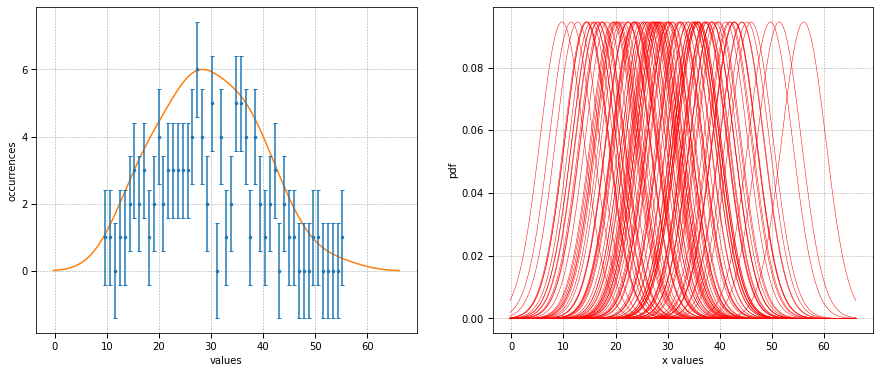

In [13]:
N=100; mean=30; std=10;
x=np.random.randn(N,1)*std+mean # random vector with normal distribution

fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax1.grid(linestyle="--", linewidth=0.6, zorder=-10);
ax1.set_xlabel('values');
ax1.set_ylabel('occurrences');
ax1.tick_params(which='major', width=1.0, length=5, labelsize=10);
ax1.tick_params(which='minor', width=1.0, length=5, labelsize=10);

H,binedges=np.histogram(x,N//2); # histogram calculation
error=np.sqrt(np.mean(H)); # error is the uncertainty of a Poisson R.V. on the y-axis (i.e. std=sqrt(var)=sqrt(mean))
ax1.errorbar(binedges[0:len(binedges)-1],H, error, fmt='.', markersize=5, capsize=2, zorder=10); # scatter plot

ax2 = fig.add_subplot(1, 2, 2);
ax2.grid(linestyle="--", linewidth=0.6, zorder=-10);
ax2.set_xlabel('x values');
ax2.set_ylabel('pdf');
ax2.tick_params(which='major', width=1.0, length=5, labelsize=10);
ax2.tick_params(which='minor', width=1.0, length=5, labelsize=10); 


std_default=1.06*std*x.size**(-1/5); # default std dev of the gaussians.

std_tuned=std_default; # std dev of the gaussians that can be tuned. The higher the smoother the KDE.

N_KDE=1000; # Number of values for the KDE (How "edgy" it is, the higher the smoother)
x_vals=np.linspace(binedges[0]-std, binedges[-1]+std, N_KDE) # x values for the KDE

KDE=np.zeros((N_KDE,));
for mean in x: #every element in x is the mean of a Gaussian R.V.
    ax2.plot(x_vals, sp.stats.norm(mean, std_tuned).pdf(x_vals), 'r', linewidth=0.5, zorder=10); # plot N(x,std_tuned)
    KDE+=sp.stats.norm(mean, std_tuned).pdf(x_vals); # sums at each iteration the gaussian N(x,std_tuned)
    
KDE=KDE/max(KDE)*max(H) # Normalization

ax1.plot(x_vals, KDE); # plot of the KDE

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

--2020-11-18 20:21:59--  https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.1
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png [following]
--2020-11-18 20:21:59--  https://www.dropbox.com/s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbc8f025d52d7e43d25bbac5c91.dl.dropboxusercontent.com/cd/0/inline/BDfDEAK3nfM5sbTNUkigFbMC_gB7zYhPgzHb3GpKxE_b1iQZCQKwEp6T_Lm68WztF5y8deffqe2973LuxiXq23oWf6MZQ5fHMeap3gd-kAj4rw/file# [following]
--2020-11-18 20:22:00--  https://ucbc8f025d52d7e43d25bbac5c91.dl.dropboxusercontent.com/cd/0/inline/BDfDEAK3nfM5sbTNUkigFbMC_gB7zYhPgzHb3GpKxE_b1iQZCQKwEp6T_Lm68WztF5y8deffqe2973LuxiXq23oWf6MZQ5fHMeap3gd

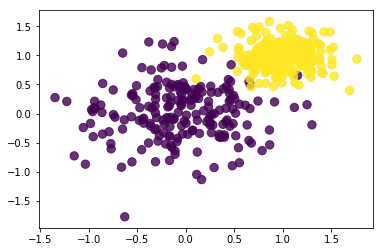

In [3]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot